In [61]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [62]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [63]:
%matplotlib inline

In [64]:
import os
import math
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

from SSMuLA.fitness_process_vis import parse_lib_stat
from SSMuLA.de_simulations import DE_COLORS, DE_TYPES, DE_LEGEND_MAP
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE, LIB_COLORS
from SSMuLA.alde_analysis import avg_alde_df
from SSMuLA.mlde_analysis import get_mlde_avg_df, get_mlde_avg_sdf
from SSMuLA.zs_analysis import (
    ZS_OPTS,
    ZS_COMB_OPTS,
    ZS_OPTS_LEGEND,
)
from SSMuLA.landscape_global import LIB_INFO_DICT, N_SAMPLE_LIST, TOTAL_N_LIST

%matplotlib inline

In [65]:
mlde_old = pd.read_csv("results/mlde/all_df_comb_onehot_4.csv")
mlde_ft = pd.read_csv("results/mlde_ft/vis/all_df.csv")
mlde_ft2 = pd.read_csv("results/mlde_ft2/vis/all_df.csv")
mlde_ft3 = pd.read_csv("results/mlde_ft3/vis/all_df.csv")

mlde_all = pd.concat([mlde_old, mlde_ft, mlde_ft2, mlde_ft3], axis=0)

In [66]:
mlde_all["ft_lib"].unique()

array([  4000,   2000,   1000,  80000,  40000,  20000,     58,     77,
           57,   8000, 149361,   7882,   7971,   7996,   7994,   7763,
         7964,   7339,   7891,   7716,   7784, 159129,   1141,   2168,
         1134,   1127,   1137,   1140,   1126,   1075,   1136,   1138,
         1121,   2243,    600,    300,    150,   1200,   6725, 159132,
          888,    500,    250,  10000,   5000,     75,     37,    125,
         2500,     18])

In [67]:
from SSMuLA.landscape_global import LIB_TYPES

In [68]:
five_zs = {
    "ev_score": PRESENTATION_PALETTE_SATURATE["green"],
    "esm_score": PRESENTATION_PALETTE_SATURATE["purple"],
    "esmif_score": PRESENTATION_PALETTE_SATURATE["yellow"],
    "coves_score": PRESENTATION_PALETTE_SATURATE["brown"],
    "Triad_score": PRESENTATION_PALETTE_SATURATE["orange"],
}

In [69]:
# FTLIB_FRAC_LIST = [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1]
FTLIB_FRAC_LIST = [0.0625, 0.125, 0.25, 0.5, 1]

In [70]:
from SSMuLA.zs_analysis import ZS_OPTS
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE

%matplotlib inline

In [71]:
ZS_OPTS

['ed_score',
 'ev_score',
 'esm_score',
 'esmif_score',
 'coves_score',
 'Triad_score']

In [72]:
lib_stat = parse_lib_stat(
    lib_csv_path="results/fitness_distribution/max/all_lib_stats.csv", n_mut_cuttoff=0
)
active_cutoff = 1
active_lib_list = lib_stat[(lib_stat["percent_active"]>=active_cutoff)]["lib"].tolist() # & (lib_stat["percent_measured"]>90)
active_lib_list

['DHFR',
 'ParD2',
 'ParD3',
 'GB1',
 'T7',
 'TEV',
 'TrpB3D',
 'TrpB3E',
 'TrpB3F',
 'TrpB3G',
 'TrpB3I',
 'TrpB4']

In [73]:
slice_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(ZS_OPTS[1:]))
        & (mlde_all["n_top"] == 96)
        & (mlde_all["n_mut_cutoff"] == "all")
        & (mlde_all["encoding"] == "one-hot")
        & (mlde_all["n_sample"]==384)
        & (mlde_all["model"] == "boosting")
    ].copy()
# map lib to number of sites use len(LIB_INFO_DICT[lib]["positions"])
slice_mlde["n_sites"] = slice_mlde["lib"].map(
    lambda x: len(LIB_INFO_DICT[x]["positions"])
)
slice_mlde

,encoding,model,n_sample,ft_lib,rep,all_maxes,all_means,top_maxes,top_means,ndcgs,rhos,if_truemaxs,truemax_inds,n_mut_cutoff,lib,zs,n_top,scale_fit,n_sites
169800,one-hot,boosting,384,4000,0,0.837839,0.160675,0.982530,0.582432,0.931561,0.512189,0.0,178.0,all,DHFR,Triad_score,96,max,3
169801,one-hot,boosting,384,4000,1,0.835335,0.163866,1.000000,0.541919,0.919135,0.520578,1.0,22.0,all,DHFR,Triad_score,96,max,3
169802,one-hot,boosting,384,4000,2,0.839829,0.157905,0.969296,0.435451,0.894345,0.528852,0.0,363.0,all,DHFR,Triad_score,96,max,3
169803,one-hot,boosting,384,4000,3,0.811491,0.171549,0.865538,0.565615,0.917335,0.499166,0.0,367.0,all,DHFR,Triad_score,96,max,3
169804,one-hot,boosting,384,4000,4,0.839540,0.174150,0.996537,0.559871,0.911455,0.507032,0.0,101.0,all,DHFR,Triad_score,96,max,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46295,one-hot,boosting,384,5000,45,0.827113,-0.038667,1.000000,0.539801,0.985920,0.214342,1.0,11.0,all,TrpB4,ev_score,96,max,4
46296,one-hot,boosting,384,5000,46,0.738836,-0.058343,0.800478,0.414861,0.985175,0.213549,0.0,1691.0,all,TrpB4,ev_score,96,max,4
46297,one-hot,boosting,384,5000,47,0.906546,-0.054249,0.932034,0.432023,0.984771,0.201442,0.0,836.0,all,TrpB4,ev_score,96,max,4
46298,one-hot,boosting,384,5000,48,0.709416,-0.059424,0.922559,0.527751,0.987828,0.215072,0.0,798.0,all,TrpB4,ev_score,96,max,4


In [74]:
slice_mlde.to_csv("/disk2/fli/SSMuLA/results4upload/mlde/ft_lib_size.csv")

In [47]:
ZS_OPTS

['ed_score',
 'ev_score',
 'esm_score',
 'esmif_score',
 'coves_score',
 'Triad_score']

In [48]:
# for avg cross number of samples
n_top = 96
frac_ft_dfs = []
for frac in FTLIB_FRAC_LIST[:-1]:
    for zs in ZS_OPTS[1:]:
        for n_site in [3, 4]:
            lib_list = slice_mlde[slice_mlde["n_sites"] == n_site]["lib"].unique()
            slice_ft_df = get_mlde_avg_sdf(slice_mlde, n_top, "all", zs, lib_list, ft_frac = frac).reset_index(drop=True)
            slice_ft_df["ft_lib_size"] = frac
            slice_ft_df["zs"] = zs
            slice_ft_df["n_site"] = n_site
            frac_ft_dfs.append(slice_ft_df)

frac_ft_df = pd.concat(frac_ft_dfs).reset_index(drop=True)
frac_ft_df


,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ft_lib_size,zs,n_site
0,0.972602,0.077579,0.888889,0.314619,0.0625,ev_score,3
1,0.700158,0.240147,0.160000,0.367834,0.0625,ev_score,4
2,0.970217,0.077880,0.831111,0.375071,0.0625,esm_score,3
3,0.660166,0.224442,0.073333,0.261556,0.0625,esm_score,4
4,0.971245,0.079828,0.882222,0.322704,0.0625,esmif_score,3
5,0.683189,0.231841,0.113333,0.318062,0.0625,esmif_score,4
6,0.959242,0.080240,0.773333,0.419141,0.0625,coves_score,3
7,0.656203,0.223412,0.073333,0.261556,0.0625,coves_score,4
8,0.891215,0.219922,0.655556,0.475716,0.0625,Triad_score,3
9,0.634793,0.202417,0.033333,0.180107,0.0625,Triad_score,4


In [49]:
ZS_OPTS_LEGEND

{'none': 'Random',
 'ed_score': 'Hamming distance',
 'Triad_score': 'Triad',
 'ev_score': 'EVmutation',
 'esm_score': 'ESM',
 'esmif_score': 'ESM-IF',
 'coves_score': 'CoVES',
 'struc-comb_score': 'Triad + ESM-IF',
 'Triad-ev_score': 'Triad + EVmutation',
 'Triad-esm_score': 'Triad + ESM',
 'msanoif-comb_score': 'EVmutation + ESM',
 'two-best_score': 'EVmutation + ESM-IF',
 'msa-comb_score': 'EVmutation + ESM + ESM-IF',
 'structnmsa-comb_score': 'Triad + EVmutation + ESM + ESM-IF'}

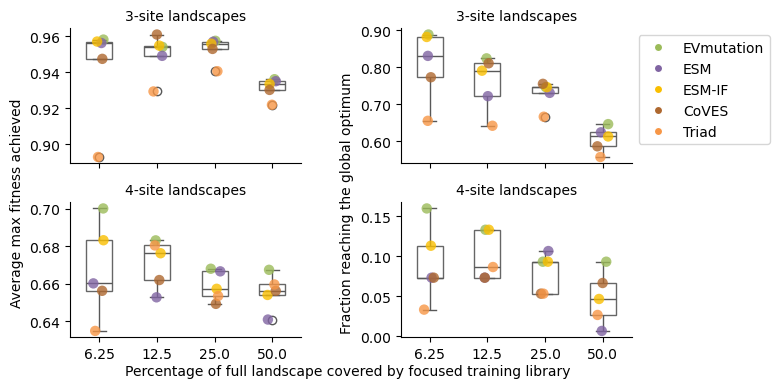

In [76]:
n_sample = 384

# mlde_color_list = ["yellow", "orange", "blue", "green", "purple", "red"]
ms = ["top_maxes_mean", "if_truemaxs_mean"]
titles = ["Average max fitness achieved", "Fraction reaching the global optimum"]

fig, axes = plt.subplots(2, 2, figsize=(8, 4), sharex=True)

for j, site in enumerate([3, 4]):

    sliced_df = frac_ft_df[frac_ft_df["n_site"] == site].copy()

    sliced_df["ft_lib_size"] = sliced_df["ft_lib_size"] * 100

    # Convert 'Category' column to categorical with defined order
    sliced_df['zs'] = pd.Categorical(sliced_df['zs'], categories=list(five_zs.keys()), ordered=True)
    
    # Sort DataFrame by 'Category'
    sliced_df = sliced_df.sort_values(by='zs')

    for i in range(2):
        ax = axes[j, i]
                # set x log
 
        sns.stripplot(
            data=sliced_df,
            x="ft_lib_size",
            y=ms[i],
            hue="zs",
            size=7.5,
            alpha=0.8,
            jitter=True,
            # style="ft_lib_size",
            marker='o',
            ax=ax,
            palette=list(five_zs.values()),
        )
        # ax.set_xscale("symlog")

        sns.boxplot(
            x="ft_lib_size",
            y=ms[i], 
            data=sliced_df,
            # showfliers=False,
            width=0.45, 
            boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],
            ax=ax,# palette="pastel", showmeans=True
            # order = np.linspace(0, 1, 9),
            # patch_artist=True
        )   
        # ax.set_xscale("log")
        # ax.set_ylim(0, 1)
        ax.set_ylabel("")
        ax.set_yticklabels([f'{y:.2f}' for y in ax.get_yticks()])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend().set_visible(False)
        ax.set_title(f"{str(site)}-site landscapes", fontsize=10)

        if j == 1:
            ax.set_ylabel(titles[i])
            # ax.tick_params(axis='x', rotation=45)
            if i == 0:
                ax.set_xlabel("Percentage of full landscape covered by focused training library")
                # shift to the right
                ax.yaxis.set_label_coords(-0.2, 1)
                ax.xaxis.set_label_coords(1.2, -0.2)
            else:
                ax.set_xlabel("")
                ax.yaxis.set_label_coords(-0.2, 1)

            # ax.set_title(titles[i])
            # ax.set_xlim(0, 1)
            # 

            # ax.set_xticks(sliced_df["ft_lib_size"].unique())
        
        
# axes[0].legend_.remove()  # Remove legend from the first subplot
legend_list = []
for zs, c in five_zs.items():
    legend_list.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, # markersize=10,
    label=ZS_OPTS_LEGEND[zs]))
axes[0, 1].legend(handles=legend_list, loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout(w_pad=-2)
fig.savefig("/disk2/fli/SSMuLA/sandbox/fig_svg/fig_s16.svg", dpi=300, bbox_inches="tight", format='svg')